In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler

from datetime import datetime as dt
import datetime
from datetime import date as dtt

 
from scipy.stats import norm, skew                              #Import Norm and skew for some statistics
from scipy import stats                                        #Import stats
import statsmodels.api as sm                                   #for decomposing the trends, seasonality etc.

from statsmodels.tsa.statespace.sarimax import SARIMAX        #for the Seasonal Forecast


from matplotlib import rcParams
import warnings
warnings.filterwarnings("ignore")

from google.oauth2.service_account import Credentials
import logging

from oauth2client.service_account import ServiceAccountCredentials

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import sqlalchemy as db
from sqlalchemy import create_engine
import mysql.connector
import psycopg2

In [2]:
# GBQ logging
import logging
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

In [55]:
data = pd.read_excel(r"C:/Users/mncedisi.mncwabe/Downloads/Data_Airlift.xlsx")

In [31]:
data.head()

,warehouse,Date,total_orders
0,EW1,2021-08-10,455
1,EW1,2021-08-11,553
2,EW1,2021-08-12,569
3,EW1,2021-08-13,426
4,EW1,2021-08-14,536


In [12]:
data.shape

(145, 3)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   warehouse     145 non-null    object        
 1   date          145 non-null    datetime64[ns]
 2   total_orders  145 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 3.5+ KB


In [14]:
data.isnull().sum()/len(data)*100

warehouse       0.0
date            0.0
total_orders    0.0
dtype: float64

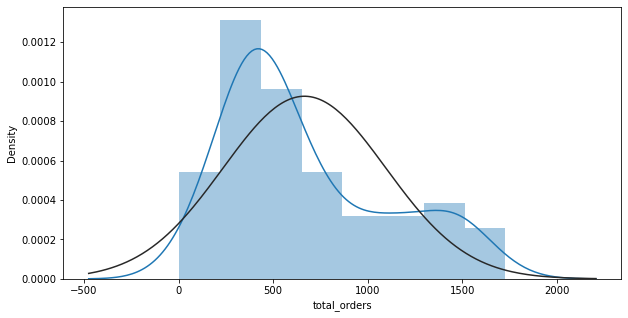

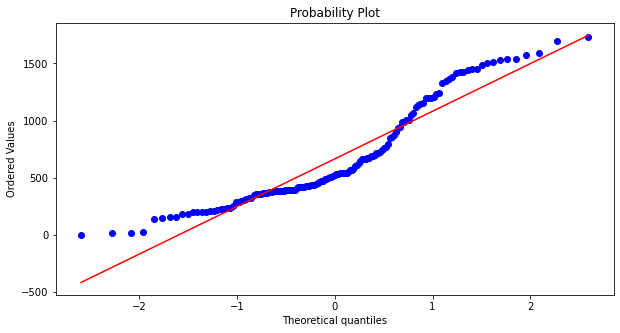

In [17]:
# distribution of Actual GMV

# figure size in inches
rcParams['figure.figsize'] = 10,5

sns.distplot(data['total_orders'],fit = norm)

#Get the QQ-plot
fig = plt.figure()
res = stats.probplot(data['total_orders'], plot = plt)
plt.show()

In [56]:
# convert date to datetime
data['Date'] = pd.to_datetime(data['Date'],errors='coerce')

In [57]:
data = data.loc[data['warehouse']=='EW2']

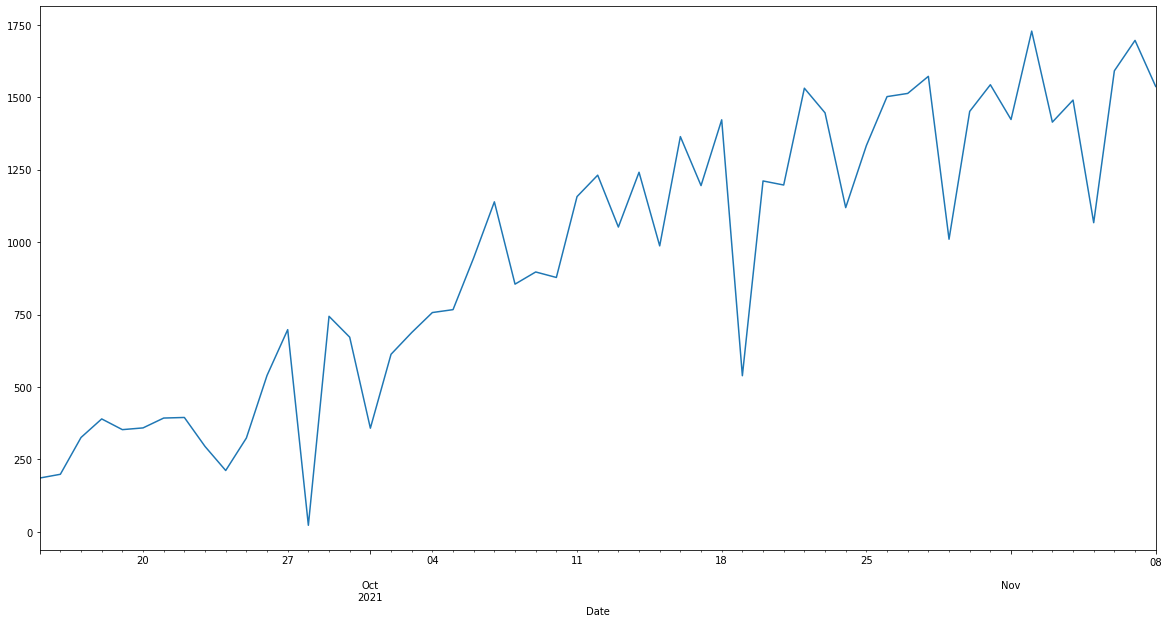

In [58]:
# Exploring the Data as TIME SERIES
# Step-01: Calculate the Total Order Qty placed on by Each Day

data = data.groupby('Date')['total_orders'].sum().reset_index()

# Step-02: Indexing the Date Column as for further processing.
data = data.set_index('Date')

# Step-03: #Averages daily sales value for the month, and use the start of each month as the timestamp.
monthly_avg_sales = data['total_orders'].resample('D').mean()

# In case there are Null values, they can be imputed using bfill.
monthly_avg_sales = monthly_avg_sales.fillna(monthly_avg_sales.bfill())

#Visualizing time series.

monthly_avg_sales.plot(figsize=(20,10))
plt.show()


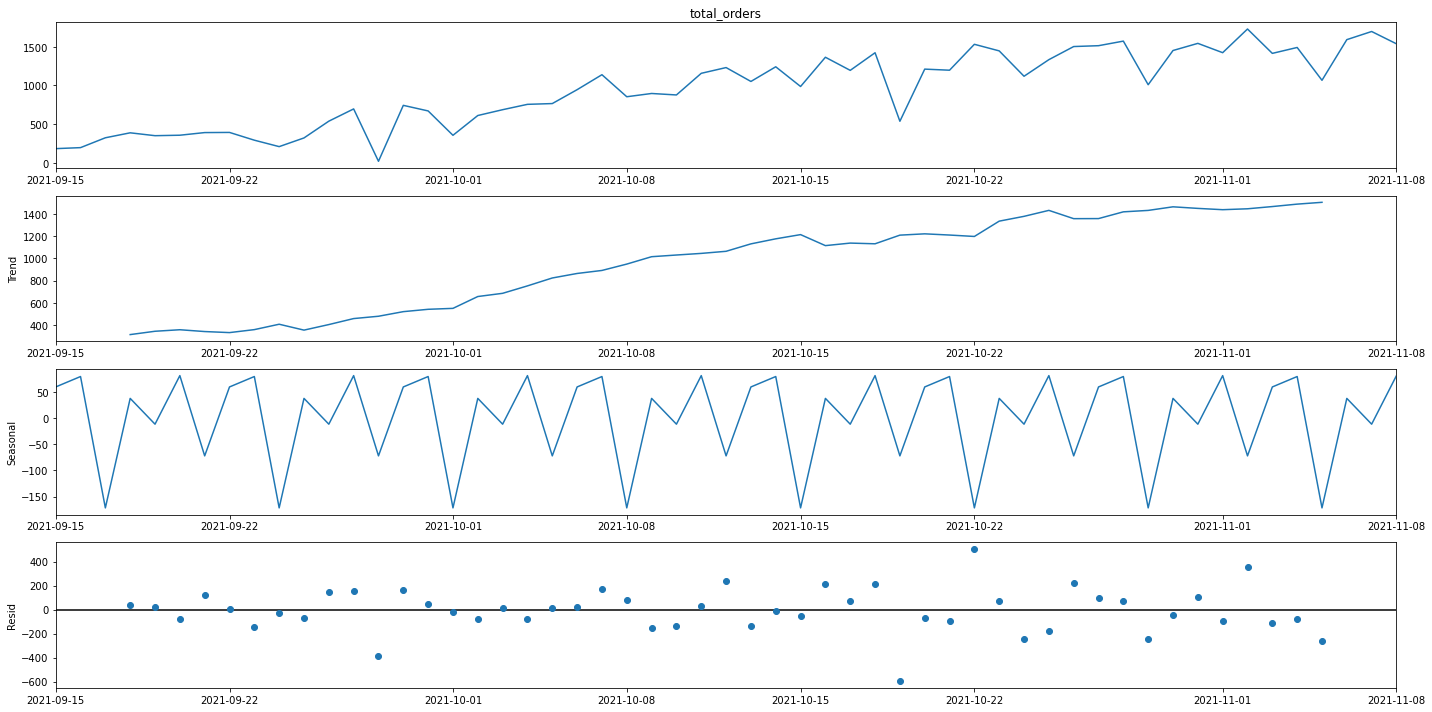

In [59]:
#Calculate the Seasonality , Trend and Residuals with Decomposition Analysis.

#Using Time Series for Decomposition. 
from pylab import rcParams

rcParams['figure.figsize'] = 20, 10
decomposition = sm.tsa.seasonal_decompose(monthly_avg_sales)
fig = decomposition.plot()
plt.show()

In [40]:
#ARIMA

# An ARIMA model is characterized by 3 terms: p, d, q where these three parameters account for seasonality (p), 
# trend (d), and noise in data (q):

# p is the order of the AR term (number of lags of Y to be used as predictors). If it rained last week, 
# it is likely it will rain tomorrow.

# q is the order of the MA term (moving average).
# d is the number of differencing required to make the time series stationary. if already stationary d=0.

# But when dealing with SEASONALITY, it is best to incorporate it as 's'. ARIMA(p,d,q)(P,D,Q)s. 
# Where 'pdq' are non seasonal params and 's' is the perdiocity of the time series. 4:quarter, 12:yearly etc.
#If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’.

In [60]:
#Grid Search and Random Search

#Since ARIMA has hyper params that can be tuned, the objective here is to find the best parameters using Grid Search.

#GRID SEARCH for Param Tuning.
#Sample params for seasonal arima. (SARIMAX).

#STEP-01:
#For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function 
#from the statsmodels module and assess its overall quality.

import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
#print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX1: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX2: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX3: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX4: {} x {}'.format(pdq[2], seasonal_pdq[4]))

#STEP-02:
#Get the best params for the data. Choose the lowest AIC.

# The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a 
# given set of data. 
# AIC measures how well a model fits the data while taking into account the overall complexity of the model.
# Large AIC: Model fits very well using a lot of features.
# Small AIC: Model fits similar fit but using lesser features. 
# Hence LOWER THE AIC, the better it is.

#The code tests the given params using sarimax and outputs the AIC scores.
# scoring='neg_mean_squared_error'

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_avg_sales,
                                            order=param,
                                            seasonal_order=param_seasonal,enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMAX1: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX2: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX3: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX4: (0, 1, 0) x (1, 0, 0, 12)
SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:909.2818603413468
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:687.2579027590282
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:632.5741052138471
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1263.0467205576952
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:639.4968866190416
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:622.840466642896
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:466.8591576924388
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1332.1751430821646
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:849.0915711487992
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:646.9800525517321
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:611.7966511167305
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1193.9560087839836
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:638.7017600291066
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:606.4750857406943
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:466.6570456707714
SARIMA(0, 0, 1

In [62]:
#Fit the model with the best params.
#SARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:27024.285317065864


#The above output suggests that ARIMA(1, 0, 1)x(1, 1, 1, 12)12 yields the lowest AIC value: 1351.1631068717465
#Therefore we should consider this to be optimal option.

from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(monthly_avg_sales,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0626      0.507     -0.124      0.902      -1.055       0.930
ma.L1         -0.8322      0.247     -3.366      0.001      -1.317      -0.348
ar.S.L12      -0.5548      0.159     -3.486      0.000      -0.867      -0.243
sigma2      8.031e+04   1.69e+04      4.748      0.000    4.72e+04    1.13e+05


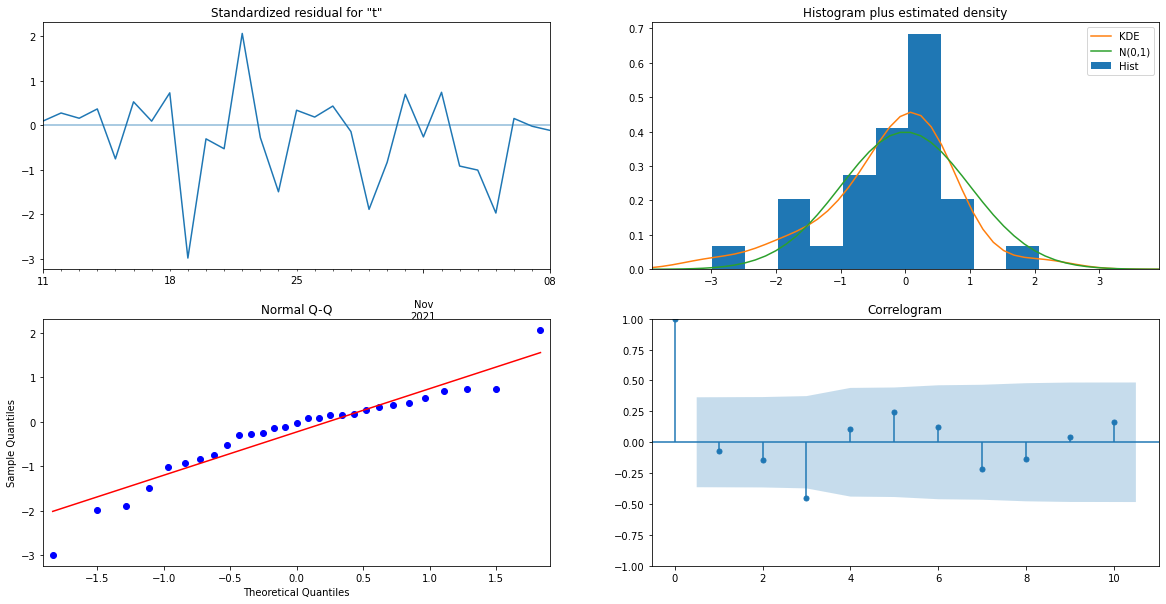

In [63]:
# Analysis of Co-efficiecnt and Standrad Error by interpeting the above Result.
#coeff: Shows weight/impotance how each feature impacts the time series. 
#Pvalue: Shows the significance of each feature weight. Can test hypothesis using this. 
# If p value is <.05 then they are statitically significant.

#Refresher on null hyp and pvalues. By default we take the null hyp as 'there is no relationship bw them'
#If p value < .05 (significance level) then you reject the Null Hypthesis If p value > .05 ,
#then you fail to reject the Null Hypothesis.

#So, if the p-value is < .05 then there is a relationship between the response and predictor. Hence, significant.

#Plotting the diagnostics.

#The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

results.plot_diagnostics(figsize=(20, 10))
plt.show()


#What are the details for analysis and check?
#1. Residuals SHOULD be Normally Distributed ; Check
#Top Right: The (orange colored) KDE line should be closely matched with green colored N(0,1) line. 
# This is the standard notation
#for normal distribution with mean 0 and sd 1.
#Bottom Left: The qq plot shows the ordered distribution of residuals (blue dots) follows the linear trend of the samples 
#taken from a standard normal distribution with N(0, 1). 

#2. #Residuals are not correlated; Check
#Top Left: The standard residuals don’t display any obvious seasonality and appear to be white noise. 
#Bottom Right: The autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have 
#low correlation with its own lagged versions.

In [64]:
monthly_avg_sales

Date
2021-09-15     186
2021-09-16     199
2021-09-17     326
2021-09-18     390
2021-09-19     353
2021-09-20     359
2021-09-21     393
2021-09-22     395
2021-09-23     295
2021-09-24     212
2021-09-25     324
2021-09-26     540
2021-09-27     698
2021-09-28      23
2021-09-29     744
2021-09-30     672
2021-10-01     358
2021-10-02     613
2021-10-03     688
2021-10-04     757
2021-10-05     767
2021-10-06     946
2021-10-07    1139
2021-10-08     855
2021-10-09     897
2021-10-10     878
2021-10-11    1157
2021-10-12    1231
2021-10-13    1052
2021-10-14    1241
2021-10-15     987
2021-10-16    1364
2021-10-17    1195
2021-10-18    1422
2021-10-19     539
2021-10-20    1211
2021-10-21    1197
2021-10-22    1531
2021-10-23    1446
2021-10-24    1119
2021-10-25    1333
2021-10-26    1502
2021-10-27    1513
2021-10-28    1572
2021-10-29    1010
2021-10-30    1451
2021-10-31    1543
2021-11-01    1423
2021-11-02    1728
2021-11-03    1414
2021-11-04    1490
2021-11-05    1067
2021-11

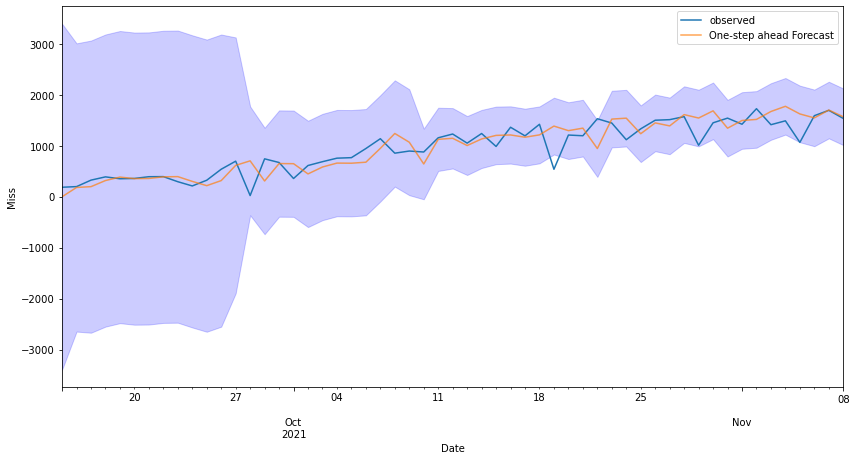

In [65]:
#Get the predictions. The forecasts start from the 06 of Macrh 2022 but the previous line shows how it fits to the data.

pred = results.get_prediction(start = None, dynamic=False)    #false is when using the entire history.


#Confidence interval.
pred_ci = pred.conf_int()

#Plotting real and forecasted values.
ax = monthly_avg_sales['2021':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Miss')
plt.legend()
plt.show()

#Takeaway: The forecats seems to be fitting well to the data. The Blue/purple thicker plot shows 
# the confidence level in the forecasts. 

In [66]:
#Calculating the Forecast Accuracy

#Calculating the mean squared error (average error of forecasts) and
#the lower Mean Square Error always reflects the better results 

y_forecasted = pred.predicted_mean
y_truth = monthly_avg_sales['2021-11-08':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))
print('RMSE: {}'.format(round(np.sqrt(mse), 2)))

MSE 1053.71
RMSE: 32.46


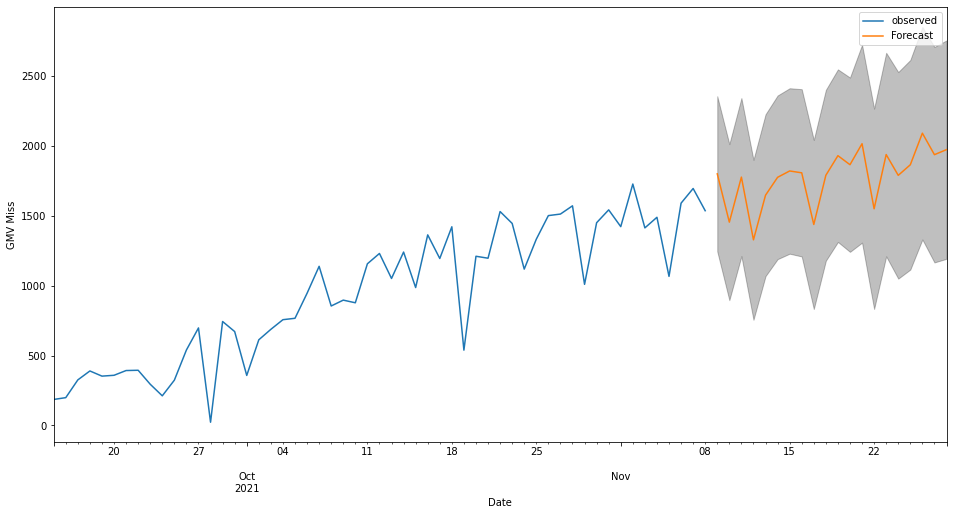

In [67]:

#We can make more changes in the time series by using below steps.
pred_uc = results.get_forecast(steps=20)
pred_ci = pred_uc.conf_int()
ax = monthly_avg_sales.plot(label='observed', figsize=(16, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('GMV Miss')
plt.legend()
plt.ticklabel_format(style='plain', axis='y')

plt.show()
 
#The grey area is the confidence we have in the predictions

In [68]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.05)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

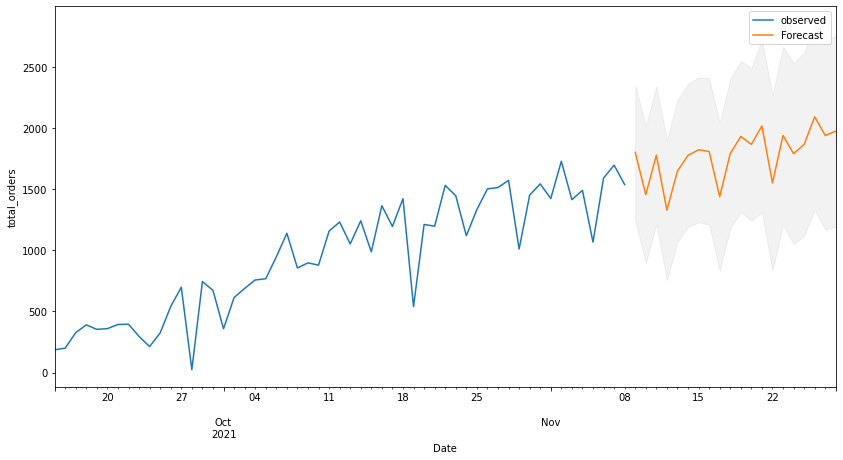

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2021-11-09,1800.879209,1245.432140,2356.326278
1,2021-11-10,1455.136032,896.623549,2013.648515
2,2021-11-11,1777.519893,1211.876590,2343.163196
3,2021-11-12,1328.581481,756.197089,1900.965874
4,2021-11-13,1647.984690,1068.919256,2227.050124


In [69]:
final_table = forecast(results,20, monthly_avg_sales)
final_table.head()

In [70]:
predictions_gmv = pred_uc.predicted_mean
predictions_gmv = pd.DataFrame({'Date':predictions_gmv.index, 'Predicted_GMV':predictions_gmv.values})
predictions_gmv.head()

,Date,Predicted_GMV
0,2021-11-09,1800.879209
1,2021-11-10,1455.136032
2,2021-11-11,1777.519893
3,2021-11-12,1328.581481
4,2021-11-13,1647.984690


In [71]:
final_table.to_csv('C:/Users/mncedisi.mncwabe/Downloads/preds_EW2.csv')